successfully parsed file HCCH3_TST.dat


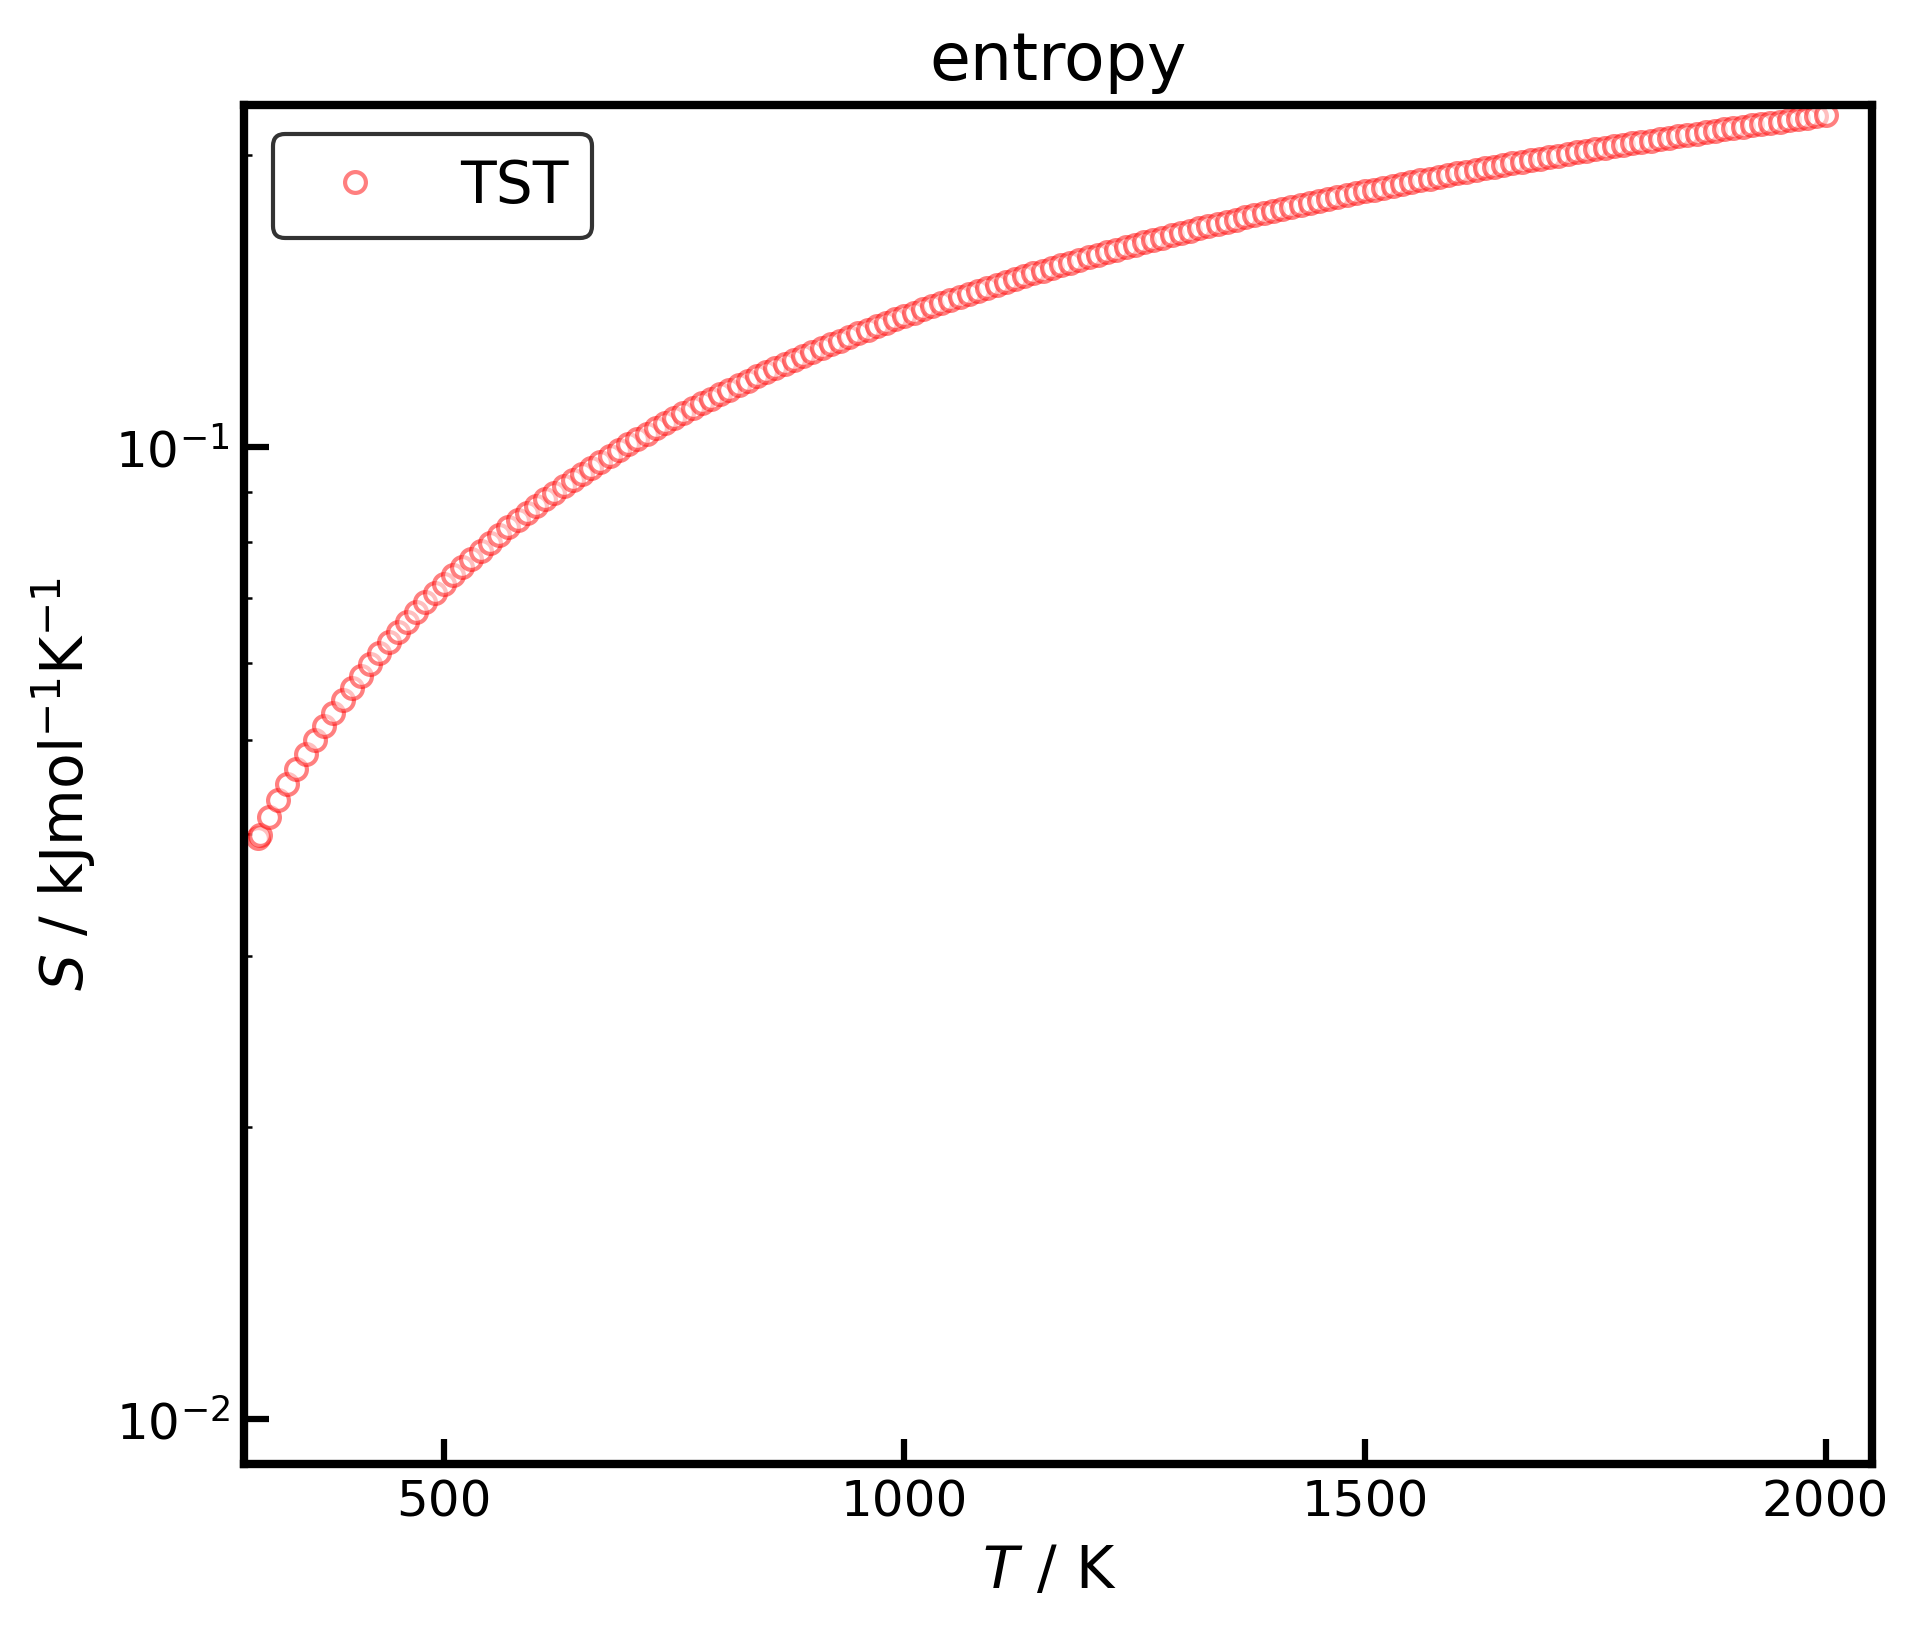

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Thu Mar  17 10:14:53 2022

@author: Katrin Blondal, Bjarne Kreitz, Franklin Goldsmith, School of Engineering, Brown University
"""

import numpy as np
import pylab
import matplotlib.pyplot  as plt
import csv
import os

plt.rcParams['figure.figsize']=(7,6)
plt.rcParams['axes.titlesize']=16
plt.rcParams['axes.linewidth'] = 2 #set the value globally
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=14)
plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.major.size']=6
plt.rcParams['xtick.major.width']=1.5
plt.rcParams['ytick.major.size']=6
plt.rcParams['ytick.major.width']=1.5
plt.rcParams['legend.edgecolor']='k'

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator, LogLocator

#Make sure to adjust the unit_cell_area based on your DFT result

# declare a class for molecules
class Molecule:
    
        def __init__(self):
                #start by defining some physical constants
                self.R = 8.3144621E-3 #ideal Gas constant in kJ/mol-K
                #self.R = 1.98720661 #ideal Gas constant in cal/mol-K
                self.kB = 1.38065e-23 #Boltzmann constant in J/K
                self.h = 6.62607e-34 #Planck constant in J*s
                self.c = 2.99792458e8 #speed of light in m/s
                self.amu = 1.6605e-27 #atomic mass unit in kg
                self.Avogadro = 6.0221E23 #mole^-1
                self.GHz_to_Hz = 1.0E9 #convert rotational constants from GHz to Hz
                self.invcm_to_invm = 1.0E2 #convert cm^-1 to m^-1, for frequencies
                self.P_ref = 1.0E5 #reference pressure, 1 bar = 1E5 Pascal
                self.hartree_to_kcalpermole = 627.5095 #convert hartree/molecule to kcal/mol
                self.hartree_to_kJpermole = 2627.25677 #convert hartree/molecule to kJ/mol
                self.eV_to_kJpermole = 96.485 #convert eV/molecule to kJ/mol
                self.T_switch = 1000.0 #K, switching temperature in NASA polynomial. Default. can overwrite.
                self.site_occupation_number = 1 #number of sites occupied by adsorbate
                self.unit_cell_area = 6.01905409150963E-19/9.0 #m2 - using surface area per binding site (nine binding sites per unit c
                self.cutoff_frequency = 100.0 #cm^-1
                self.twoD_gas = False
                
# create the array of temperatures in 5 degree increments
temperature = [298.15] #NOTE 298.15 must be first for the NASA polynomial routine to work!
T_low = 300
T_high = 2000
dT = 10.0 #temperature increment
temperature = np.append(temperature, np.arange(T_low, T_high+dT, dT) )

# HERE BEGINS THE LONG LIST OF SUBROUTINES
#-------------------------------------------------------------------------
# subroutine for the translational mode
def get_translation_thermo(molecule,temperature):
    # unpack the constants (not essential, but makes it easier to read)
    R = molecule.R
    kB = molecule.kB
    h = molecule.h
    amu = molecule.amu
    P_ref = molecule.P_ref
    

    #initialize the arrays for the partition function and the entropy
    Q_trans  = np.ones(len(temperature)) 
    S_trans  = np.zeros(len(temperature))

    if molecule.twoD_gas:
        m = molecule.adsorbate_mass
        pi = np.pi
        area = molecule.unit_cell_area
        sites = molecule.site_occupation_number
        print("switching to 2D-gas for 2 lowest modes for %s"%molecule.name)
        # cycle through each temperature
        for (i,T) in enumerate(temperature):
            # partition function is: (2*pi*mass*kB*T/h**2)^(2/2) * area
            if (1==0): #3D gas, really here just for inspiration
                V = kB*T/P_ref #This is volume per molecule of an ideal gas
                Q_trans[i] = (2*pi*m*amu*kB*T/h**2)**(1.5) * V
                S_trans[i] = R * (2.5 + np.log( Q_trans[i] )) 

            else: #surface
                if (1==0): #Campbell + Arnadottir
                    V = kB*T/P_ref
                    Q_trans[i] = (2*pi*m*amu*kB*T/h**2)**(1.0) *V**0.66667
                    S_trans[i] = R * (2.0 + np.log( Q_trans[i] ))   

                else: #area is not a function of temperature
                    Q_trans[i] = (2*pi*m*amu*kB*T/h**2) * area * sites
                    S_trans[i] = R * (2.0 + np.log( Q_trans[i] ))

       
    # add the results to the thermo object
    molecule.Q_trans = Q_trans
    molecule.S_trans = S_trans
    return

# subroutine for the vibrational mode
def get_vibrational_thermo(molecule,temperature):
    units = 1.0
    units *= molecule.h * molecule.c / molecule.kB * molecule. invcm_to_invm # K*cm
    
    #initialize the arrays for the partition function and the entropy
    Q_vib_tst  = np.ones(len(temperature))
    S_vib_tst  = np.zeros(len(temperature))
    
    for (t,temp) in enumerate(temperature):
        for (n,nu) in enumerate(molecule.frequencies):
            if molecule.twoD_gas==True and n <= 1: #skip the first two if we do 2D gas
                #do nothing!
                Q_vib_tst[t] *= 1.0
                S_vib_tst[t] += 0.0
            else:
                x = nu * units / temp #cm^-1 * K cm / K = dimensionless
                Q_vib_tst[t]  *= 1.0 / (1.0 - np.exp( - x) )
                S_vib_tst[t]  += -np.log( 1.0 - np.exp( - x ) ) + x * np.exp( - x) / (1.0 - np.exp( - x) ) 
        S_vib_tst[t]  *= molecule.R
    # add the results to the thermo object
    molecule.Q_vib_tst = Q_vib_tst
    molecule.S_vib_tst = S_vib_tst
    return

#-------------------------------------------------------------------------
#create the main thermo function that calls the individual modes
def thermo(molecule, temperature):
    
    # call the subroutine for the vibrational partition function
    get_translation_thermo(molecule,temperature)
    get_vibrational_thermo(molecule,temperature)
    
    # note that the partition function is the production of the individual terms,
    # whereas the thermodynamic properties are additive
    molecule.Q_tst = molecule.Q_trans * molecule.Q_vib_tst
    molecule.S_tst = molecule.S_trans + molecule.S_vib_tst
    return
#-------------------------------------------------------------------------
#compare NASA fits to computed fits
def plot_thermo(temperature, molecule):
    
    fig = pylab.figure(dpi=300,figsize=(7,6))
    gs = gridspec.GridSpec(1, 1)
    gs.update(wspace = 0.5)
    ax2 = plt.subplot(gs[0])

    ax2.semilogy(temperature, molecule.S_tst, marker='o', markeredgecolor='r',color='w',alpha=0.5,linestyle='None', markersize=5, label='TST')

    ax2.set_ylim(10e-3*0.9, max(molecule.S_tst)*1.025)
    ax2.yaxis.set_major_locator(LogLocator(base=10.0, numticks=4))     
        
    ax2.set_xlim(min(temperature)*0.95, max(temperature)*1.025)
    ax2.xaxis.set_major_locator(MaxNLocator(4))
    ax2.tick_params(direction='in', axis='both', which='major', labelsize=12)
    ax2.tick_params(direction='in', axis='both', which='minor')
    ax2.set_title("entropy")
    ax2.set_xlabel("$T\ /\ \mathrm{K}$  ", fontsize=14)
    ax2.set_ylabel("$S\ /\ \mathrm{kJ mol^{-1} K^{-1}}$", fontsize=14)
    plt.legend()
    #plt.savefig('Thermo_CH3.pdf', bbox_inches='tight')

    ###Write the partition function and temperature into a text file
    myFields = ['temperature', 'q', 'S']
    myData = zip(temperature, molecule.Q_tst, molecule.S_tst)
    myFile = open(species_list[0].replace('.dat\n','.txt'), 'w')  
    with myFile as output:
        writer = csv.writer(output, lineterminator='\n', delimiter='\t')
        writer.writerow(myFields)
        writer.writerows(myData)  
       
    return

#-------------------------------------------------------------------------
#This would be a good place to define the input parser
def parse_input_file(inputfile, molecule, element1):
    
    #script_dir= '.././' #the path to the C, N, O and/or H folders that contain input files for each adsorbate
    script_dir=''
    rel_path = str(element1) + "/" + str(inputfile)
    abs_file_path = os.path.join(script_dir, rel_path)
    
    input_file = open(abs_file_path,'r')
    lines = input_file.readlines()
    input_file.close()
    
    error_name = True
    error_composition = True
    error_sites = True
    error_adsorbate_mass = True
    error_frequencies = True
      
    for line in lines:
        #start by looking for the name
        if line.strip().startswith("name"):
            bits = line.split('=')
            name = bits[1].strip().replace("'","").replace('"','')
            molecule.name = name
            error_name = False
        #now look for the composition    
        elif line.strip().startswith("composition"):
            bits = line.split('=') 
            composition = bits[1].strip().replace("{","").replace("}","").split(',')
            molecule.composition = {}
            for pair in composition:
                element, number = pair.split(":")
                element = element.strip().replace("'","").replace('"','')
                number = int(number)
                molecule.composition[element]=number
            N_adsorbate_atoms = 0
            for element in molecule.composition:
                if element!='Pt':
                    N_adsorbate_atoms += molecule.composition[element]            
            error_composition = False
        #now look for the site occupancy    
        elif line.strip().startswith("sites"):
            bits = line.split('=') 
            site_occupation_number = int(bits[1])
            molecule.site_occupation_number = site_occupation_number
            error_sites = False  
        #now look for the molecule mass   
        elif line.strip().startswith("adsorbate_mass"):
            bits = line.split('=') 
            adsorbate_mass_info = bits[1].strip().replace("[","").replace("]","").split(',')
            adsorbate_mass = float(adsorbate_mass_info[0])
            units = adsorbate_mass_info[1].strip().replace("'","").replace('"','')
            if units=='amu':
                molecule.adsorbate_mass = adsorbate_mass
                molecule.adsorbate_mass_units = units.strip()
                error_adsorbate_mass = False
            else:
                print ("Adsorbate mass is missing proper units!\n Please use either 'eV' or 'kJ/mol'")
                break
        #now look for the frequencies  of the transition state   
        elif line.strip().startswith("frequencies"):
            bits = line.split('=')
            freq_info = bits[1].strip().replace("[","").replace("]","").split(',')
            N_freq_computed = 3*N_adsorbate_atoms-1
            if len(freq_info)!=N_freq_computed+1:
                print ("ERROR: The number of frequencies is not what was expected\n %d expected, but only %d received"%(N_freq_computed, len(freq_info)-1))
            units = freq_info[-1]    
            if units=='eV' or units!='cm-1':
                molecule.frequencies_units = units.strip()
                molecule.frequencies = []
                for i in range(len(freq_info)-1):
                    molecule.frequencies.append(float(freq_info[i]))
                error_frequencies = False
                #if the two lowest frequencies are less than the cutoff value (This assumes that they are sorted!)
                if molecule.frequencies[1]<molecule.cutoff_frequency:
                    #print "switching to 2D-gas for 2 lowest modes for %s"%name
                    molecule.twoD_gas = False
                                                 
    if error_name or error_composition or error_frequencies:
        print ("Input file is missing information: %s"%(inputfile))
    else:
        print ("successfully parsed file %s"%(inputfile))
    return

list_of_species = 'species_list.dat'
element = 'C' #varies
info = open(list_of_species,'r')
species_list = info.readlines()
info.close()

counter = -1
for species in species_list:
    counter += 1
    filename = species.strip()
    test = Molecule()
    parse_input_file(filename, test, element)
    thermo(test, temperature)
    
    plot_thermo(temperature, test)
